# **Utilities**

In [19]:
pip install pydub

In [20]:
!gdown --id 1bmGQzOVd3kF5cspMAMk1O6kqqOSdVr1y
!gdown --id 1oM85b9knjJgRnId6OyXP6EFaBRIL0ahI
!gdown --id 13dHQ5JtZNcWZOFEFHUgT5GMVFH6GzUOL

Downloading...
From: https://drive.google.com/uc?id=1bmGQzOVd3kF5cspMAMk1O6kqqOSdVr1y
To: /content/1sabuk_aus.mp3
100% 420k/420k [00:00<00:00, 6.53MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oM85b9knjJgRnId6OyXP6EFaBRIL0ahI
To: /content/2bunyipiston.mp3
100% 121k/121k [00:00<00:00, 3.79MB/s]
Downloading...
From: https://drive.google.com/uc?id=13dHQ5JtZNcWZOFEFHUgT5GMVFH6GzUOL
To: /content/3rusaklep.mp3
100% 123k/123k [00:00<00:00, 3.89MB/s]


# **Persiapan Train**

In [21]:
# CNN dan MFCC
# Convolutional Neural Network dan Mel Frequency Cepstrum Coefficients

import numpy as np # Ini buat array
import cv2 # Ini buat gambar

import matplotlib.pyplot as plt
%matplotlib inline

import pydub # Ini buat mbaca mp3
import librosa # Ini buat MFCC

# Ini fungsi buat mbaca mp3
def read(f, normalized=False):

  a = pydub.AudioSegment.from_mp3(f)
  y = np.array(a.get_array_of_samples())
  if a.channels == 2:
      y = y.reshape((-1, 2))
  if normalized:
      return a.frame_rate, np.float32(y) / 2**15
  else:
      return a.frame_rate, y
  
# Mbaca Suaranya
frekuensi_aus,    suara_aus      = read('1sabuk_aus.mp3')
frekuensi_piston, suara_piston   = read('2bunyipiston.mp3')
frekuensi_klep,   suara_klep     = read('3rusaklep.mp3')
#
suara_aus     = suara_aus[:,0].astype(float)
suara_piston  = suara_piston[:,0].astype(float)
suara_klep    = suara_klep[:,0].astype(float)
#
print("detik aus          : ",(suara_aus.shape[0]/frekuensi_aus))
print("detik piston       : ",(suara_piston.shape[0]/frekuensi_piston))
print("detik klep         : ",(suara_klep.shape[0]/frekuensi_klep))
# Ukuran Disamaratain
ukuran_terkecil = 0
if suara_aus.shape[0] < suara_piston.shape[0]:
  ukuran_terkecil = suara_aus.shape[0]
elif suara_piston.shape[0] < suara_klep.shape[0]:
  ukuran_terkecil = suara_piston.shape[0]
else:
  ukuran_terkecil = suara_klep.shape[0]
ukuran_terkecil //= frekuensi_piston             #ukuran terkecil 9
print("Ukuran terkecil    : ",ukuran_terkecil)
#
amplitude_tergede = 0
amplitude_terkecil = 999
for i in range(ukuran_terkecil):
  mfcc = librosa.feature.mfcc(suara_klep[frekuensi_klep*i:frekuensi_klep*(i+1)], sr=frekuensi_klep) # (20, 87)
  
  nilai_max = np.max(mfcc)
  nilai_min = np.min(mfcc)
  if nilai_max > amplitude_tergede:
      amplitude_tergede = nilai_max
  if nilai_min < amplitude_terkecil:
      amplitude_terkecil = nilai_min
print("Amplitude Terkecil : ",amplitude_terkecil)
print("Amplitude Terbesar : ",amplitude_tergede)

      

detik aus          :  26.192108843537415
detik piston       :  9.99482993197279
detik klep         :  10.141473922902493
Ukuran terkecil    :  9
Amplitude Terkecil :  -134.9863262586935
Amplitude Terbesar :  950.0912938026278


In [37]:
pydub.AudioSegment.from_mp3('3rusaklep.mp3') 

# **train untuk mendapatkan nilai X dan Y**

nilai X :  (27, 20, 87, 1)
nilai Y :  [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
AxesImage(54,36;334.8x217.44)


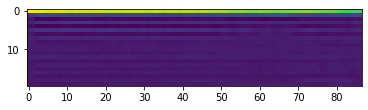

In [23]:
# Persiapan x_train

x_train = []
for i in range(ukuran_terkecil):
    mfcc = librosa.feature.mfcc(suara_aus[frekuensi_aus*i:frekuensi_aus*(i+1)], sr=frekuensi_aus)
    mfcc = (mfcc + 200)/1000
    x_train.append(mfcc)
    
for i in range(ukuran_terkecil):
    mfcc = librosa.feature.mfcc(suara_piston[frekuensi_piston*i:frekuensi_piston*(i+1)], sr=frekuensi_piston)
    mfcc = (mfcc + 200)/1000
    x_train.append(mfcc)

for i in range(ukuran_terkecil):
    mfcc = librosa.feature.mfcc(suara_klep[frekuensi_klep*i:frekuensi_klep*(i+1)], sr=frekuensi_klep)
    mfcc = (mfcc + 200)/1000
    x_train.append(mfcc)

x_train = np.asarray(x_train)   #=27, 20,87                     
x_train = x_train.reshape(27, 20, 87, 1)       

# Persiapan y_train
y_train = []
for i in range(9):
    y_train.append(0)
for i in range(9):
    y_train.append(1)
for i in range(9):
    y_train.append(2)
y_train = np.asarray(y_train)

print("nilai X : ", x_train.shape)
print("nilai Y : ", y_train)
print(plt.imshow(mfcc))

# **CNN OTAKE**

In [30]:
# Ini Otak CNN-nya
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Arsitektur 3 layer, 32-8 filter ukuran 3x3
classifier = Sequential()

classifier.add(Conv2D(32, (3, 3), input_shape = (20, 87, 1), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Conv2D(16, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Conv2D(8, (3, 3), activation = 'relu'))
classifier.add(Flatten())

classifier.add(Dense(units = 100, activation = 'relu'))
classifier.add(Dense(units = 3, activation = 'softmax'))

classifier.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

#classifier.summary()                 #nampilin 
# classifier.fit_generator
classifier.fit(x_train, y_train, epochs=30, batch_size=4)

Epoch 1/30
7/7 [==============================] - 0s 8ms/step - loss: 1.1111 - accuracy: 0.2222
Epoch 2/30
7/7 [==============================] - 0s 8ms/step - loss: 1.0997 - accuracy: 0.3333
Epoch 3/30
7/7 [==============================] - 0s 8ms/step - loss: 1.1039 - accuracy: 0.2593
Epoch 4/30
7/7 [==============================] - 0s 8ms/step - loss: 1.0989 - accuracy: 0.3333
Epoch 5/30
7/7 [==============================] - 0s 7ms/step - loss: 1.0971 - accuracy: 0.3333
Epoch 6/30
7/7 [==============================] - 0s 8ms/step - loss: 1.0964 - accuracy: 0.3333
Epoch 7/30
7/7 [==============================] - 0s 8ms/step - loss: 1.0968 - accuracy: 0.3333
Epoch 8/30
7/7 [==============================] - 0s 8ms/step - loss: 1.0939 - accuracy: 0.3333
Epoch 9/30
7/7 [==============================] - 0s 9ms/step - loss: 1.0906 - accuracy: 0.3333
Epoch 10/30
7/7 [==============================] - 0s 9ms/step - loss: 1.0922 - accuracy: 0.3704
Epoch 11/30
7/7 [======================

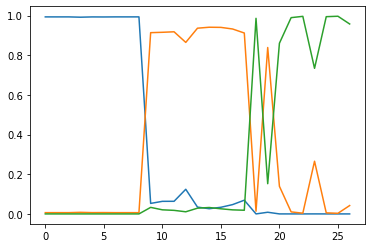

In [31]:
hasil_prediksi = classifier.predict(x_train)
plt.plot(hasil_prediksi)

# **FUNSGI PREDIKSI**

hasil Prediksi :  [<matplotlib.lines.Line2D object at 0x7f31c6d7c6d0>, <matplotlib.lines.Line2D object at 0x7f31c6d7c8d0>, <matplotlib.lines.Line2D object at 0x7f31c6d7ca90>]


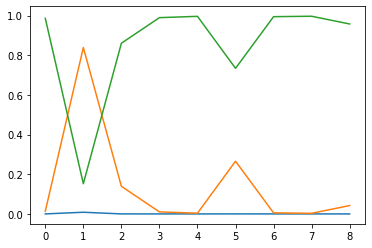

In [35]:
def haha(d): 
  sr_test, x_test = read(d)
  x_test = x_test[:,0].astype(float)
  siapasaya = []
  for i in range(ukuran_terkecil):
      mfcc = librosa.feature.mfcc(x_test[frekuensi_piston*i:frekuensi_piston*(i+1)], sr=frekuensi_piston)
      mfcc = (mfcc + 200)/1000
      siapasaya.append(mfcc)
  siapasaya = np.asarray(siapasaya)
  siapasaya = siapasaya.reshape(9, 20, 87, 1)
  hasil_prediksi_siapasaya = classifier.predict(siapasaya)
  print("hasil Prediksi : ", plt.plot(hasil_prediksi_siapasaya))

haha('3rusaklep.mp3')

In [27]:
classifier.save_weights('suara.h5')

model_json = classifier.to_json()
with open("suara.json", "w") as json_file:
    json_file.write(model_json)

# **Code For Show Image From Sound**

In [28]:



#pydub.AudioSegment.from_mp3('itu.mp3') 


# Bentuk Suaranya
#plt.plot(x_itu[sample_itu*2:sample_itu*3])  #menampilkan detike ke 2 sampai ke 3
#plt.show()

#mfcc = librosa.feature.mfcc(x_karena[sample_itu*20:sample_itu*21], sr=sample_itu) #menampilkan detike 20 sampai dengan detik ke 21
#plt.imshow(mfcc)


#mfcc.shape
# Ukuran Disamaratain
#ukuran_terkecil = 0
#if x_karena.shape[0] < x_itu.shape[0]:
#    ukuran_terkecil = x_karena.shape[0]
#else:
#    ukuran_terkecil = x_itu.shape[0]
#ukuran_terkecil //= sample_itu
#print(ukuran_terkecil)



# Prediksi
#hasil_prediksi = classifier.predict(x_train)
#plt.plot(hasil_prediksi)